# 03__activs_general

in this notebook, i look at activities (determined by MPRAnalyze) for sequences -- neg. ctrls, pos. ctrls, by biotype, etc. i also correlate these activities w/ endogenous expression. finally, since every TSS has 2 tiles, i take the maximum activity tile per TSS in order to continue on with cross-species comparisons.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def cleaner_biotype(row, biotype_col):
    try:
        if row["name"] == "random_sequence":
            return "negative control"
        elif "samp" in row.element:
            return "positive control"
        else:
            if row[biotype_col] in ["protein_coding", "div_pc"]:
                return "mRNA"
            elif row[biotype_col] == "intergenic":
                return "lincRNA"
            elif row[biotype_col] in ["antisense", "div_lnc"]:
                return "lncRNA"
            elif row[biotype_col] == "enhancer":
                return "eRNA"
            elif row[biotype_col] == "no cage activity":
                return "no CAGE activity"
            else:
                return "other"
    except:
        if row[biotype_col] in ["protein_coding", "div_pc"]:
            return "mRNA"
        elif row[biotype_col] == "intergenic":
            return "lincRNA"
        elif row[biotype_col] in ["antisense", "div_lnc"]:
            return "lncRNA"
        elif row[biotype_col] == "enhancer":
            return "eRNA"
        elif row[biotype_col] == "no cage activity":
            return "no CAGE activity"
        else:
            return "other"

In [5]:
def is_sig(row, col):
    if row[col] < 0.05:
        return "sig"
    else:
        return "not sig"

In [6]:
def fix_cage_exp(row, col):
    if row[col] == "no cage activity":
        return 0
    else:
        return float(row[col])

## variables

In [7]:
data_dir = "../../../data/02__mpra/02__activs"
alpha_f = "%s/alpha_per_elem.quantification.txt" % data_dir

In [8]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [9]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.UPDATED.txt"

## 1. import files

In [10]:
alpha = pd.read_table(alpha_f, sep="\t")
alpha.reset_index(inplace=True)
alpha.head()

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
0,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,2.307972,1.965289,6.836813e-66,3.296419e-24,1.196572e-64,4.966103e-23
1,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,0.573923,0.485477,7.714719e-03,1.168301e-01,2.558485e-02,3.666646e-01
2,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,0.315190,0.295362,4.085087e-01,4.806001e-01,6.631957e-01,7.220042e-01
3,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,0.235547,0.177407,6.711073e-01,7.454044e-01,7.826055e-01,8.000145e-01
4,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,0.431180,0.376351,1.124697e-01,2.962260e-01,2.746731e-01,6.347699e-01


In [11]:
index = pd.read_table(index_f, sep="\t")

In [12]:
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [13]:
tss_map = pd.read_table(tss_map_f, sep="\t", index_col=0)
tss_map.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,har,orig_species,lift_species,oligo_type,hg19_id,mm9_id
0,chr1,2984981,2984982,-,"chr1:2984976..2984989,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.1,0.43,0.027777800000000002,0.0175,False,human,mouse,human__divergent:mouse__divergent,h.0,m.0
1,chr1,2985002,2985003,-,"chr1:2984997..2985037,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.29,0.43,0.0311111,0.0175,False,human,mouse,human__divergent:mouse__divergent,h.1,m.0
2,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,2.54,0.85,0.07111110000000001,0.0,False,human,mouse,human__divergent:mouse__divergent,h.2,m.1
3,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,0.3,0.14,0.10444400000000001,0.0,False,human,mouse,human__divergent:mouse__antisense,h.3,m.2
4,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,0.19,0.25,0.03,0.0,False,human,mouse,human__antisense:mouse__protein_coding,h.4,m.3


## 2. merge alphas w/ index

In [14]:
pos_ctrls = alpha[alpha["index"].str.contains("__samp")]
pos_ctrls["HUES64_log"] = np.log10(pos_ctrls["HUES64"])
pos_ctrls["mESC_log"] = np.log10(pos_ctrls["mESC"])
len(pos_ctrls)

400

In [15]:
alpha = alpha[~alpha["index"].str.contains("__samp")]
len(alpha)

13479

In [16]:
data = alpha.merge(index_elem, left_on="index", right_on="element", how="left")
data.drop("index", axis=1, inplace=True)
data.head()

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
0,2.307972,1.965289,6.836813e-66,3.296419e-24,1.196572e-64,4.966103e-23,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,WILDTYPE,MOUSE_EVO_TSS__m.3163__tile1:53114165-53114309...,MOUSE_EVO_TSS__m.3163__tile1,1.0,chr11,-,53114165,53114309,8265.1.0.0
1,0.573923,0.485477,7.714719e-03,1.168301e-01,2.558485e-02,3.666646e-01,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile1:129255098-1292552...,HUMAN_EVO_TSS__h.1133__tile1,1.0,chrX,-,129255098,129255242,7281.1.0.0
2,0.315190,0.295362,4.085087e-01,4.806001e-01,6.631957e-01,7.220042e-01,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,WILDTYPE,MOUSE_EVO_TSS__m.596__tile2:136753021-13675316...,MOUSE_EVO_TSS__m.596__tile2,1.0,chr6,-,136753021,136753165,12910.1.0.0
3,0.235547,0.177407,6.711073e-01,7.454044e-01,7.826055e-01,8.000145e-01,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,WILDTYPE,MOUSE_EVO_TSS__m.2358__tile2:15536411-15536555...,MOUSE_EVO_TSS__m.2358__tile2,1.0,chr14,-,15536411,15536555,9294.1.0.0
4,0.431180,0.376351,1.124697e-01,2.962260e-01,2.746731e-01,6.347699e-01,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,WILDTYPE,HUMAN_EVO_TSS__h.1436__tile1:157192113-1571922...,HUMAN_EVO_TSS__h.1436__tile1,1.0,chr2,+,157192113,157192257,4134.1.0.0


In [17]:
data["HUES64_log"] = np.log10(data["HUES64"])
data["mESC_log"] = np.log10(data["mESC"])
data.sample(5)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,HUES64_log,mESC_log
5895,0.826834,0.626688,2.514188e-06,2.070156e-02,1.198297e-05,8.995745e-02,CTCACAAGCATCTGCAGACTGAAGCCTGACATCCAAGCTCCGGCTC...,WILDTYPE,MOUSE_EVO_TSS__m.265__tile1:101129073-10112921...,MOUSE_EVO_TSS__m.265__tile1,1.0,chr15,-,101129073,101129217,9730.1.0.0,-0.082582,-0.202948
10316,0.303286,0.324069,4.480489e-01,4.124914e-01,6.891861e-01,7.021024e-01,GTGTTGTTGCCTAGAGTTTGTCCCAGCGGAGGGTTGGCTTCGGATC...,WILDTYPE,HUMAN_EVO_TSS__h.508__tile2:232646166-23264631...,HUMAN_EVO_TSS__h.508__tile2,1.0,chr2,+,232646166,232646310,4323.1.0.0,-0.518147,-0.489362
4206,2.388898,1.808445,4.224610e-71,3.116171e-20,7.776309e-70,4.161393e-19,CCCAGAACCTGCGCGAGGGAGACGCCCCTCCTCTGGCCCCGCCCCA...,WILDTYPE,MOUSE_EVO_TSS__m.2627__tile2:59966640-59966784...,MOUSE_EVO_TSS__m.2627__tile2,1.0,chr8,+,59966640,59966784,13593.1.0.0,0.378198,0.257305
8727,0.191485,0.121667,7.927675e-01,8.401374e-01,8.327561e-01,8.584053e-01,GGACAGATGGATCGTCTGCGGTGCAGGTCACGGTACTCGTCAACAC...,RANDOM,random_sequence_270;270,random_sequence,0.0,NaN,NaN,0,0,none,-0.717866,-0.914828
6673,0.184230,0.149278,8.098896e-01,7.964811e-01,8.419818e-01,8.279933e-01,CTTGGATAATACAGACTACTGTCCGAGCGGCCGCGCACCCTTGTGT...,RANDOM,random_sequence_729;729,random_sequence,0.0,NaN,NaN,0,0,none,-0.734640,-0.826005


## 3. compare negative controls to TSSs & positive controls
maybe delete this section

In [18]:
neg_ctrls = data[data["tile_type"] == "RANDOM"]
others = data[data["tile_type"] != "RANDOM"]

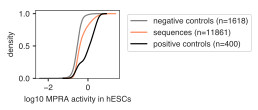

In [19]:
plt.figure(figsize=(1.5, 1.25))
sns.kdeplot(neg_ctrls["HUES64_log"], label="negative controls (n=%s)" % len(neg_ctrls), 
             color="gray", cumulative=True)
sns.kdeplot(others["HUES64_log"], label="sequences (n=%s)" % len(others), 
             color=sns.color_palette("Set2")[1], cumulative=True)
sns.kdeplot(pos_ctrls["HUES64_log"], label="positive controls (n=%s)" % len(pos_ctrls), 
             color="black", cumulative=True)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.ylabel("density")
plt.xlabel("log10 MPRA activity in hESCs")

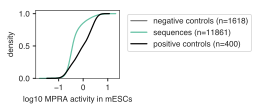

In [20]:
plt.figure(figsize=(1.5, 1.25))
sns.kdeplot(neg_ctrls["mESC_log"], label="negative controls (n=%s)" % len(neg_ctrls), 
             color="gray", cumulative=True)
sns.kdeplot(others["mESC_log"], label="sequences (n=%s)" % len(others), 
             color=sns.color_palette("Set2")[0], cumulative=True)
sns.kdeplot(pos_ctrls["mESC_log"], label="positive controls (n=%s)" % len(pos_ctrls), 
             color="black", cumulative=True)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.ylabel("density")
plt.xlabel("log10 MPRA activity in mESCs")

## 4. compare activities across biotypes + controls

In [21]:
data["tss_id"] = data["name"].str.split("__", expand=True)[1]
data["species"] = data["name"].str.split("_", expand=True)[0]
data["tss_tile_num"] = data["name"].str.split("__", expand=True)[2]
data.sample(5)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,...,chrom,strand,actual_start,actual_end,dupe_info,HUES64_log,mESC_log,tss_id,species,tss_tile_num
358,0.215277,0.397383,0.730592,0.254096,0.801953,0.593633,AACCTTAGTTGATGGCTGTCCAGCCGGCTGGTTCTTCCCTATTCAA...,WILDTYPE,HUMAN_EVO_TSS__h.2548__tile1:128446499-1284466...,HUMAN_EVO_TSS__h.2548__tile1,...,chr3,+,128446499,128446643,4984.1.0.0,-0.667002,-0.400791,h.2548,HUMAN,tile1
727,0.295919,0.207433,0.472810,0.684273,0.701982,0.775144,AATCCCTCACCTTAAACACTGGCCTGCACCACCAAGAAAAGAGAAA...,WILDTYPE,HUMAN_EVO_TSS__h.2549__tile1:53293783-53293927...,HUMAN_EVO_TSS__h.2549__tile1,...,chr5,+,53293783,53293927,5559.1.0.0,-0.528828,-0.683121,h.2549,HUMAN,tile1
11453,0.400576,1.022892,0.169949,0.000005,0.376071,0.000036,TCGAACATTCCACGTATCAACCCCACTAGCTAATGGGCCGGAATCT...,RANDOM,random_sequence_95;95,random_sequence,...,NaN,NaN,0,0,none,-0.397315,0.009830,None,random,None
8967,0.265694,0.410323,0.574447,0.229829,0.749671,0.564428,GGCAGCAATGACTTGGTTGAAGCCAGAAACACGGCTCAGGGAGGGC...,WILDTYPE,MOUSE_EVO_TSS__m.1478__tile1:118164327-1181644...,MOUSE_EVO_TSS__m.1478__tile1,...,chr11,+,118164327,118164471,8690.1.0.0,-0.575618,-0.386874,m.1478,MOUSE,tile1
12430,0.253772,0.286702,0.613579,0.501350,0.766435,0.729031,TGGTAAAAGTTCTCACTAATCCTCAATATTCCACTTTTTAAAATCT...,WILDTYPE,HUMAN_EVO_TSS__h.2883__tile2:26100209-26100353...,HUMAN_EVO_TSS__h.2883__tile2,...,chr2,+,26100209,26100353,3765.1.0.0,-0.595556,-0.542569,h.2883,HUMAN,tile2


In [22]:
pos_ctrls.columns = ["element", "HUES64", "mESC", "HUES64_pval", "mESC_pval", "HUES64_padj", "mESC_padj", 
                     "HUES64_log", "mESC_log"]
pos_ctrls.head()

,element,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,HUES64_log,mESC_log
13479,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,2.644918,2.416868,6.414319e-89,8.629020e-38,1.431259e-87,1.730168e-36,0.422412,0.383253
13480,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,2.970383,3.365748,1.644934e-114,1.081427e-76,4.826646e-113,4.274873e-75,0.472812,0.527082
13481,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,2.619446,3.127998,4.690231e-87,1.263620e-65,1.028368e-85,4.234957e-64,0.418209,0.495267
13482,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,2.676060,2.474041,3.168534e-91,9.769663e-40,7.317153e-90,2.011188e-38,0.427496,0.393407
13483,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,3.132718,2.984473,1.665483e-128,2.266498e-59,5.610494e-127,6.821620e-58,0.495921,0.474868


In [23]:
human_df = data[(data["species"] == "HUMAN") | (data["name"] == "random_sequence")]
mouse_df = data[(data["species"] == "MOUSE") | (data["name"] == "random_sequence")]

human_df_w_ctrls = human_df.append(pos_ctrls)
mouse_df_w_ctrls = mouse_df.append(pos_ctrls)

human_df_w_ctrls = human_df_w_ctrls.merge(tss_map[["hg19_id", "biotype_hg19", "stem_exp_hg19", "orig_species"]], 
                                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df_w_ctrls = mouse_df_w_ctrls.merge(tss_map[["mm9_id", "biotype_mm9", "stem_exp_mm9", "orig_species"]], 
                                          left_on="tss_id", right_on="mm9_id", how="left")
mouse_df_w_ctrls.sample(5)

,HUES64,HUES64_log,HUES64_padj,HUES64_pval,actual_end,actual_start,chrom,dupe_info,element,element_id,...,species,strand,tile_number,tile_type,tss_id,tss_tile_num,mm9_id,biotype_mm9,stem_exp_mm9,orig_species
4536,0.321630,-0.492643,0.645429,0.387471,24812491.0,24812347.0,chr18,10258.1.0.0,CTGGCTTCCAGATGGCGCTGGAAGGCCGGGGGCTCAGGGCCCCGCT...,MOUSE_EVO_TSS__m.1705__tile2:24812347-24812491...,...,MOUSE,-,1.0,WILDTYPE,m.1705,tile2,m.1705,no cage activity,no cage activity,human
7015,0.371656,-0.429858,0.479640,0.239008,136942476.0,136942332.0,chr2,11071.1.0.0,GTCCCGGCTCCCAGACCGGCGCTCCGGGTCCCTTCGAGAGCCAGGC...,MOUSE_EVO_TSS__m.523__tile1:136942332-13694247...,...,MOUSE,-,1.0,WILDTYPE,m.523,tile1,m.523,protein_coding,1.2425,human
7581,0.306478,-0.513601,0.683443,0.437380,0.0,0.0,NaN,none,TACTTAAGCAAACGACCCCAGCGATAATCCCGGCAGAAATTTAGCC...,random_sequence_344;344,...,random,NaN,0.0,RANDOM,None,None,NaN,NaN,NaN,NaN
7716,0.144340,-0.840614,0.898119,0.887864,0.0,0.0,NaN,none,TATAGACTCCGTCTATCGCTGGTGGAGTGAAGATAAGTGTTTGGAA...,random_sequence_1384;1384,...,random,NaN,0.0,RANDOM,None,None,NaN,NaN,NaN,NaN
4675,0.223201,-0.651304,0.794557,0.707986,65083724.0,65083580.0,chr11,8334.1.0.0,CTTCGGGCATCCGATTTAGGGGTGCCAGTGCAGAGACTCCCGCCTG...,"MOUSE_EVO_TSS__m.656__tile2:65083580-65083724,...",...,MOUSE,-,1.0,WILDTYPE,m.656,tile2,m.656,protein_coding,0.03125,human


In [24]:
human_df_w_ctrls["cleaner_biotype"] = human_df_w_ctrls.apply(cleaner_biotype, biotype_col="biotype_hg19", axis=1)
mouse_df_w_ctrls["cleaner_biotype"] = mouse_df_w_ctrls.apply(cleaner_biotype, biotype_col="biotype_mm9", axis=1)
human_df_w_ctrls.cleaner_biotype.value_counts()

eRNA                2415
no CAGE activity    1879
negative control    1618
mRNA                1439
lncRNA               902
other                606
lincRNA              597
positive control     400
Name: cleaner_biotype, dtype: int64

In [25]:
ctrl_order = ["negative control", "eRNA", "lincRNA", "lncRNA", "mRNA", "positive control"]

human_ctrl_pal = {"negative control": "gray", "no CAGE activity": "gray", "eRNA": sns.color_palette("Set2")[1],
                  "lincRNA": sns.color_palette("Set2")[1], "lncRNA": sns.color_palette("Set2")[1], 
                  "mRNA": sns.color_palette("Set2")[1], "positive control": "black"}

mouse_ctrl_pal = {"negative control": "gray", "no CAGE activity": "gray", "eRNA": sns.color_palette("Set2")[0],
                  "lincRNA": sns.color_palette("Set2")[0], "lncRNA": sns.color_palette("Set2")[0], 
                  "mRNA": sns.color_palette("Set2")[0], "positive control": "black"}

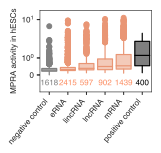

In [26]:
fig = plt.figure(figsize=(2, 1.5))
ax = sns.boxplot(data=human_df_w_ctrls, x="cleaner_biotype", y="HUES64", flierprops = dict(marker='o', markersize=5),
                 order=ctrl_order, palette=human_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in hESCs")

for i, label in enumerate(ctrl_order):
    n = len(human_df_w_ctrls[human_df_w_ctrls["cleaner_biotype"] == label])
    color = human_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 20))
fig.savefig("better_neg_ctrl_boxplot.human.pdf", dpi="figure", bbox_inches="tight")

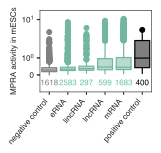

In [27]:
fig = plt.figure(figsize=(2, 1.5))
ax = sns.boxplot(data=mouse_df_w_ctrls, x="cleaner_biotype", y="mESC", flierprops = dict(marker='o', markersize=5),
                 order=ctrl_order, palette=mouse_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in mESCs")

for i, label in enumerate(ctrl_order):
    n = len(mouse_df_w_ctrls[mouse_df_w_ctrls["cleaner_biotype"] == label])
    color = mouse_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 20))
fig.savefig("better_neg_ctrl_boxplot.mouse.pdf", dpi="figure", bbox_inches="tight")

## 5. compare activities across tiles

In [28]:
df = data[data["tss_tile_num"].isin(["tile1", "tile2"])]
human_df = df[df["species"] == "HUMAN"]
mouse_df = df[df["species"] == "MOUSE"]

human_df = human_df.merge(tss_map[["hg19_id", "biotype_hg19", "stem_exp_hg19", "orig_species"]], left_on="tss_id", 
                          right_on="hg19_id", how="right")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "biotype_mm9", "stem_exp_mm9", "orig_species"]], left_on="tss_id", 
                          right_on="mm9_id", how="right")
mouse_df.sample(5)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,...,dupe_info,HUES64_log,mESC_log,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,stem_exp_mm9,orig_species
5076,0.327170,0.471795,0.369633,0.133764,0.630223,0.402337,CGTTTGGCGCCCGGTGTGTGGCCTTGCATATCCTTGCAGTGAAAAG...,WILDTYPE,MOUSE_EVO_TSS__m.1969__tile2:11315038-11315182...,MOUSE_EVO_TSS__m.1969__tile2,...,11691.1.0.0,-0.485226,-0.326247,m.1969,MOUSE,tile2,m.1969,no cage activity,no cage activity,human
3065,0.301142,0.306400,0.455239,0.454232,0.692985,0.715192,TGGGTGGCATTCAATCTTGGGTTTCATGCATTTTTTAAACCTGCTG...,WILDTYPE,MOUSE_EVO_TSS__m.1025__tile1:167744315-1677444...,MOUSE_EVO_TSS__m.1025__tile1,...,"7687.1.0.0,7688.1.0.0",-0.521228,-0.513711,m.1025,MOUSE,tile1,m.1025,enhancer,0.0,human
4305,0.703173,0.755057,0.000219,0.002471,0.000882,0.013202,TGCCTTTCCCCCTGGCTCTAGTGGGCCGGTTCCTCTATCCAATGTC...,WILDTYPE,"MOUSE_EVO_TSS__m.712__tile1:45866558-45866702,...",MOUSE_EVO_TSS__m.712__tile1,...,14197.1.0.0,-0.152938,-0.122020,m.712,MOUSE,tile1,m.712,protein_coding,12.725,human
1841,0.603984,0.165537,0.003718,0.767740,0.012893,0.812106,GATTTCTATCATGTCCGCCTCTCCACAGGCAAGCGGGGGGGGGGGG...,WILDTYPE,MOUSE_EVO_TSS__m.1358__tile2:106680099-1066802...,MOUSE_EVO_TSS__m.1358__tile2,...,11890.1.0.0,-0.218974,-0.781106,m.1358,MOUSE,tile2,m.1358,no cage activity,no cage activity,human
3205,0.416298,0.771434,0.138411,0.001812,0.322478,0.009913,CAAGTTGCCCTTCCTGGAGCTTTCTGGGCTGGTTTCTAGGCTGCCC...,WILDTYPE,MOUSE_EVO_TSS__m.356__tile1:143581134-14358127...,MOUSE_EVO_TSS__m.356__tile1,...,12505.1.0.0,-0.380596,-0.112701,m.356,MOUSE,tile1,m.356,enhancer,0.014170600000000002,human


1.18758928942e-70
5.59643727638e-65


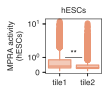

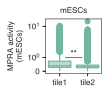

In [29]:
for df, species, colname, color in zip([human_df, mouse_df], ["hESCs", "mESCs"], ["HUES64", "mESC"], [sns.color_palette("Set2")[1], sns.color_palette("Set2")[0]]):
    fig = plt.figure(figsize=(1, 1))
    ax = sns.boxplot(data=df, x="tss_tile_num", y=colname, flierprops = dict(marker='o', markersize=5),
                     color=color)
    mimic_r_boxplot(ax)

    # calc p-vals b/w dists
    tile1_dist = np.asarray(df[df["tss_tile_num"] == "tile1"][colname])
    tile2_dist = np.asarray(df[df["tss_tile_num"] == "tile2"][colname])

    tile1_dist = tile1_dist[~np.isnan(tile1_dist)]
    tile2_dist = tile2_dist[~np.isnan(tile2_dist)]

    tile_u, tile_pval = stats.mannwhitneyu(tile1_dist, tile2_dist, alternative="two-sided", use_continuity=False)
    print(tile_pval)

    annotate_pval(ax, 0.2, 0.8, 1, 0, 1, tile_pval, fontsize)
    ax.set_yscale('symlog')
    ax.set_ylabel("MPRA activity\n(%s)" % species)
    ax.set_xlabel("")
    ax.set_title(species)

## 6. find max activity per tile

In [30]:
human_df_sort = human_df[["element", "tss_id", "biotype_hg19", "tss_tile_num", "HUES64", "HUES64_log", "HUES64_padj"]].sort_values(by=["tss_id", "HUES64_log"], ascending=False)
human_df_max = human_df_sort.groupby(["tss_id", "biotype_hg19"]).head(1)
human_df_max["HUES64_sig"] = human_df_max.apply(is_sig, col="HUES64_padj", axis=1)
human_df_max.head(10)

,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig
6273,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,1.848145e-02,sig
6923,GGGCGGGACGGAGACTCTGGGCTCAAGGCTCCTGGAAATGGGCGGG...,h.998,div_pc,tile2,0.885958,-0.052587,1.044316e-06,sig
93,AAAAGGCAGTGCTTGATTCAATTCAACATTCACTGCGCCACTTACC...,h.997,div_pc,tile2,0.423129,-0.373527,2.996315e-01,not sig
4217,CGGAGGGGCGGGGCAAGAGTGGGAGGAGACCCTGCGCGCGGCCGCC...,h.996,div_pc,tile2,2.452145,0.389546,5.019212e-74,sig
2195,AGGGTGGTGCGTGGTCTACGGCGAGCGGAGTGGGGCGGGGTCGCGC...,h.995,div_pc,tile1,0.994045,-0.002594,6.400385e-09,sig
971,ACACCCGAACCAGCAGCGAGAGAAGGAGCCCGGCATGCGGCGACTC...,h.993,div_pc,tile1,3.279297,0.515781,2.902582e-140,sig
7252,TGATTGGTAGGTGCGATGTTGACCACCAGGGAAAGTCCACCTTCCC...,h.992,div_pc,tile2,0.781899,-0.106850,6.424087e-05,sig
2128,CGGGAGGCGCGGCTTCGTGGGCATGTAGTCCAATCAGGGCCGCGCT...,h.991,div_pc,tile1,1.102384,0.042333,1.682828e-11,sig
3821,CCATGAAACAGGCCCTGGGGAGACTGAAGGAGAGCGGCGCGAGCGA...,h.990,div_pc,tile2,0.562421,-0.249938,3.265717e-02,sig
4867,CGGGCGGGGCCCGGGACTGCGGTGCTGCGCCCGAGCACGTACTGAG...,h.99,intergenic,tile1,0.341774,-0.466261,5.849553e-01,not sig


In [31]:
mouse_df_sort = mouse_df[["element", "tss_id", "biotype_mm9", "tss_tile_num", "mESC", "mESC_log", "mESC_padj"]].sort_values(by=["tss_id", "mESC_log"], ascending=False)
mouse_df_max = mouse_df_sort.groupby(["tss_id", "biotype_mm9"]).head(1)
mouse_df_max["mESC_sig"] = mouse_df_max.apply(is_sig, col="mESC_padj", axis=1)
mouse_df_max.head(10)

,element,tss_id,biotype_mm9,tss_tile_num,mESC,mESC_log,mESC_padj,mESC_sig
76,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.432170,0.385994,5.320842e-37,sig
5223,CTCATCCCGGCGCAGTGATACGAGGCGCACCAATGAGTTCAAATGT...,m.997,div_pc,tile1,1.213309,0.083971,1.124766e-07,sig
932,GAGGCCGGGAAGGGGGCGGGGGAAAGAGGGAGAGAACAGCGTTTGA...,m.996,protein_coding,tile1,1.708776,0.232685,8.261865e-17,sig
6577,GCGCCTGAGGGCGGAGATGGGCGTGGAGCAAAGATGGGCCGGGGGC...,m.994,protein_coding,tile1,0.416619,-0.380261,5.491396e-01,not sig
472,AACTCCAGACGAACCCTAACTTTGCAGGAAAAGAAGACTCCCTACT...,m.993,no cage activity,tile1,0.293595,-0.532251,7.229937e-01,not sig
7305,GTAGTAGTTTCTATCCATCGGAGTAGCCCTCACCTCTGATTGGACA...,m.992,protein_coding,tile1,0.747698,-0.126274,1.496012e-02,sig
4593,CCTCCTGCAAAAACTCAGGGCTCAGAGCTCCGCCCCGATGTTTTTA...,m.990,protein_coding,tile2,0.710125,-0.148665,2.752991e-02,sig
5937,GAATCGGTAGCCTCCCGCCCAAGGTCTGCAGGCTTTCTTCCGTTCT...,m.99,intergenic,tile1,0.427120,-0.369450,5.241302e-01,not sig
5136,TTACCTGAGCGCGCCTCTGCCAATGGCAGCTCACCTGAGGGAGCAC...,m.989,div_pc,tile1,1.368727,0.136317,3.968039e-10,sig
604,AAGCCTCTTGGGCAGTATTGGGTCACGTCCCGGCCATCGCCGTGTC...,m.988,protein_coding,tile1,0.811953,-0.090469,4.712050e-03,sig


In [32]:
human_df_max["cleaner_biotype"] = human_df_max.apply(cleaner_biotype, biotype_col="biotype_hg19", axis=1)
mouse_df_max["cleaner_biotype"] = mouse_df_max.apply(cleaner_biotype, biotype_col="biotype_mm9", axis=1)
print(len(human_df_max))
print(len(mouse_df_max))

3345
3261


In [33]:
ctrls = human_df_w_ctrls[human_df_w_ctrls["cleaner_biotype"].isin(["negative control", "positive control"])]
len(ctrls)

2018

In [34]:
human_tmp = human_df_max.append(ctrls)
mouse_tmp = mouse_df_max.append(ctrls)

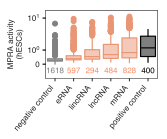

In [35]:
# re-make boxplots with neg/pos ctrls
fig = plt.figure(figsize=(2, 1.25))
ax = sns.boxplot(data=human_tmp, x="cleaner_biotype", y="HUES64", flierprops = dict(marker='o', markersize=5),
                 order=ctrl_order, palette=human_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity\n(hESCs)")

for i, label in enumerate(ctrl_order):
    n = len(human_tmp[human_tmp["cleaner_biotype"] == label])
    color = human_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.75), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 20))
fig.savefig("better_neg_ctrl_boxplot.human_max.pdf", dpi="figure", bbox_inches="tight")

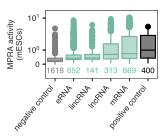

In [36]:
# re-make boxplots with neg/pos ctrls
fig = plt.figure(figsize=(2, 1.25))
ax = sns.boxplot(data=mouse_tmp, x="cleaner_biotype", y="mESC", flierprops = dict(marker='o', markersize=5),
                 order=ctrl_order, palette=mouse_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity\n(mESCs)")

for i, label in enumerate(ctrl_order):
    n = len(mouse_tmp[mouse_tmp["cleaner_biotype"] == label])
    color = mouse_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.75), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 20))
fig.savefig("better_neg_ctrl_boxplot.mouse_max.pdf", dpi="figure", bbox_inches="tight")

## 7. correlate MPRA activities w/ endogenous activities

consider re-doing w/ RNA-seq

In [37]:
human_tmp = human_df_max.merge(human_df[["element", "stem_exp_hg19"]].drop_duplicates(), on="element")
len(human_tmp)

3548

In [38]:
human_tmp["stem_exp_hg19_fixed"] = human_tmp.apply(fix_cage_exp, col="stem_exp_hg19", axis=1)
human_tmp.sample(5)

,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype,stem_exp_hg19,stem_exp_hg19_fixed
2534,AAGTAGTGGTTTAGCAACACCAGGCGGCTCTATGATGCTAAAATAA...,h.1779,div_lnc,tile1,0.404570,-0.393006,3.621946e-01,not sig,lncRNA,0.20666700000000002,0.206667
789,CTGCTATTTTTGTTGTTGTTGTTGTTTGCAACATACATTTCAACAC...,h.3488,no cage activity,tile2,0.314102,-0.502929,6.661304e-01,not sig,no CAGE activity,no cage activity,0.000000
2953,AAAAGCATCTAAACCCTAGGGGAATGTCGGCAATGTGGGCTTGGCA...,h.1371,enhancer,tile1,1.045769,0.019436,4.192108e-10,sig,eRNA,0.185441,0.185441
2821,AGTACAGTGACTCGGGACTGGAGGTGACACATACCCTCGAGCCTGA...,h.1494,enhancer,tile1,0.278208,-0.555630,7.307612e-01,not sig,eRNA,0.0,0.000000
998,GGAAGCCGCAGGCCCGGCCCCCTCACCCATGCGGGCCGCCAACCGA...,h.3284,no cage activity,tile2,0.378289,-0.422176,4.552606e-01,not sig,no CAGE activity,no cage activity,0.000000


In [39]:
biotypes_sub = ["eRNA", "lincRNA", "lncRNA", "mRNA"]

eRNA
597
0.205386210822
lincRNA
294
0.345146689655
lncRNA
483
0.200737320037
mRNA
828
0.436145820018


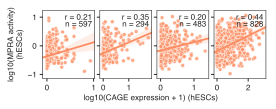

In [40]:
fig, axes = plt.subplots(figsize=(4, 1.25), nrows=1, ncols=len(biotypes_sub), sharex=False, sharey=True)
for i, biotype in enumerate(biotypes_sub):
    print(biotype)
    ax = axes[i]
    sub = human_tmp[human_tmp["cleaner_biotype"] == biotype]
    
    sub["stem_exp_hg19_log"] = np.log10(sub["stem_exp_hg19_fixed"] + 1)
    sub = sub[~pd.isnull(sub["HUES64_log"])]
    print(len(sub))
    
    sns.regplot(data=sub, x="stem_exp_hg19_log", y="HUES64_log", color=human_ctrl_pal[biotype], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub['stem_exp_hg19_log'], sub['HUES64_log'])
    print(r_value)
    
    ax.text(0.95, 0.95, "r = {:.2f}".format(r_value), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.85, "n = %s" % (len(sub)), ha="right", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel("log10(MPRA activity)\n(hESCs)")
    else:
        ax.set_ylabel("")
        
plt.text(0.5, -0.05, "log10(CAGE expression + 1) (hESCs)", ha="center", va="top", 
             transform=plt.gcf().transFigure, fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)
plt.show()

fig.savefig("cage_corr_human.biotype_sub.pdf", dpi="figure", bbox_inches="tight")

In [41]:
mouse_tmp = mouse_df_max.merge(mouse_df[["element", "stem_exp_mm9"]].drop_duplicates(), on="element")
mouse_tmp["stem_exp_mm9_fixed"] = mouse_tmp.apply(fix_cage_exp, col="stem_exp_mm9", axis=1)
len(mouse_tmp)

3402

eRNA
659
0.353032733129
lincRNA
141
0.125084732501
lncRNA
312
0.411090584744
mRNA
869
0.521734653275


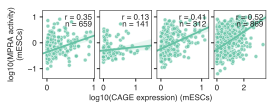

In [42]:
fig, axes = plt.subplots(figsize=(4, 1.25), nrows=1, ncols=len(biotypes_sub), sharex=False, sharey=True)
for i, biotype in enumerate(biotypes_sub):
    print(biotype)
    ax = axes[i]
    sub = mouse_tmp[mouse_tmp["cleaner_biotype"] == biotype]
    
    sub["stem_exp_mm9_log"] = np.log10(sub["stem_exp_mm9_fixed"] + 1)
    sub = sub[~pd.isnull(sub["mESC_log"])]
    print(len(sub))
    
    sns.regplot(data=sub, x="stem_exp_mm9_log", y="mESC_log", color=mouse_ctrl_pal[biotype], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub['stem_exp_mm9_log'], sub['mESC_log'])
    print(r_value)
    
    ax.text(0.95, 0.95, "r = {:.2f}".format(r_value), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.85, "n = %s" % (len(sub)), ha="right", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel("log10(MPRA activity)\n(mESCs)")
    else:
        ax.set_ylabel("")
        
plt.text(0.5, -0.05, "log10(CAGE expression) (mESCs)", ha="center", va="top", 
             transform=plt.gcf().transFigure, fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)
plt.show()

fig.savefig("cage_corr_mouse.biotype_sub.pdf", dpi="figure", bbox_inches="tight")

## 8. write files

In [43]:
human_df_filename = "%s/human_TSS_vals.both_tiles.txt" % data_dir
mouse_df_filename = "%s/mouse_TSS_vals.both_tiles.txt" % data_dir
human_df_max_filename = "%s/human_TSS_vals.max_tile.txt" % data_dir
mouse_df_max_filename = "%s/mouse_TSS_vals.max_tile.txt" % data_dir

In [44]:
human_df.to_csv(human_df_filename, sep="\t", index=False)
mouse_df.to_csv(mouse_df_filename, sep="\t", index=False)
human_df_max.to_csv(human_df_max_filename, sep="\t", index=False)
mouse_df_max.to_csv(mouse_df_max_filename, sep="\t", index=False)